# Data Augmentations Check

## Preprocessing:
Here we will check what effects torchio transformations have on each volume
1. Crop or Pad
2. Mask - normalisation using label as a mask
3. One Hot Encoding

### Load data using the data_prep code
**NB: DO NOT RUN THE DATA PREPROC PART YET**

To ensure we are just working with a few functions at a time, py script is copied in below without preproc. We will run each example on several SSA and GLI datasets

#### Some functions from scripts

In [1]:
import subprocess

try:
    import numpy as np
    import matplotlib.pyplot as plt
    import nibabel as nib
    import os
    import random
    from matplotlib.colors import ListedColormap
    import torch
    import json
    from glob import glob
    import time
    import numpy as np
    from matplotlib import rcParams 
    import torchio as tio
except ModuleNotFoundError as e:
    package = str(e).split("'")[0]
    subprocess.run(['pip', 'install', package])

In [3]:
# Read in data files

# CHANGE data_dir path as per your local set up
pthAlex = '/Users/alexandrasmith/Desktop/Workspace/Projects/UNN_BraTS23/data/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData/'
pthAly = 'C:\\Users\\amoda\\Documents\\SPARK\\BraTS2023\\Data\\Samples\\'

data_dir = pthAly
print(data_dir)
specific_string = 'BraTS-'
# folders = os.listdir(data_dir)
subject_dirs = sorted([os.path.join(data_dir, subject_dir) for subject_dir in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subject_dir)) and subject_dir.startswith(specific_string)])

print("Total folders: ", len(subject_dirs), "\n Subjects:\n",  "\n".join(subject_dirs))

# Iterate through the subject folders
subjects = []
for subject_dir in subject_dirs:
    subject_id = os.path.basename(subject_dir)
    print(subject_dir)
    # Create a list to hold the subject's images and labels
    images = []
    labels = []

    # Load each scan modality and segmentation
    for modality in ['t1n', 't1c', 't2w', 't2f']:
        image_path = os.path.join(subject_dir, f'{subject_id}-{modality}.nii.gz')
        image = tio.ScalarImage(image_path)
        images.append(image)

    label_path = os.path.join(subject_dir, f'{subject_id}-seg.nii.gz')
    label = tio.LabelMap(label_path)
    labels.append(label)

    # Create the subject using the images and labels
    subject = tio.Subject(
        t1n=images[0],
        t1c=images[1],
        t2w=images[2],
        t2f=images[3],
        seg=labels[0],
        name=subject_id
    )
    subjects.append(subject)
# Create the dataset with the subject
dataset = tio.SubjectsDataset(subjects)

C:\Users\amoda\Documents\SPARK\BraTS2023\Data\Samples\
Total folders:  12 
 Subjects:
 C:\Users\amoda\Documents\SPARK\BraTS2023\Data\Samples\BraTS-GLI-00002-000
C:\Users\amoda\Documents\SPARK\BraTS2023\Data\Samples\BraTS-GLI-00016-001
C:\Users\amoda\Documents\SPARK\BraTS2023\Data\Samples\BraTS-GLI-00054-000
C:\Users\amoda\Documents\SPARK\BraTS2023\Data\Samples\BraTS-GLI-00305-000
C:\Users\amoda\Documents\SPARK\BraTS2023\Data\Samples\BraTS-GLI-00406-000
C:\Users\amoda\Documents\SPARK\BraTS2023\Data\Samples\BraTS-GLI-01035-000
C:\Users\amoda\Documents\SPARK\BraTS2023\Data\Samples\BraTS-SSA-00002-000
C:\Users\amoda\Documents\SPARK\BraTS2023\Data\Samples\BraTS-SSA-00012-000
C:\Users\amoda\Documents\SPARK\BraTS2023\Data\Samples\BraTS-SSA-00046-000
C:\Users\amoda\Documents\SPARK\BraTS2023\Data\Samples\BraTS-SSA-00047-000
C:\Users\amoda\Documents\SPARK\BraTS2023\Data\Samples\BraTS-SSA-00081-000
C:\Users\amoda\Documents\SPARK\BraTS2023\Data\Samples\BraTS-SSA-00112-000
C:\Users\amoda\Documents\

In [5]:
#Select one subject to Explore
specific_string = 'BraTS-'
# folders = os.listdir(data_dir)
folders = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder)) and folder.startswith(specific_string)]

print("Total folders: ", len(folders), "\n Subjects: ",  folders)
#randomly select a subject
img_folder = folders[random.randrange(0, len(folders))]
print(f"Working with subject: {img_folder}")

## Set up files
# Load image volumes
img_volumes = [nib.load(os.path.join(data_dir + img_folder, img_folder + f"-{m}.nii.gz")) for m in ["t1c", "t1n", "t2f", "t2w"]]

# Load segmentation volume
seg_volume = nib.load(os.path.join(data_dir + img_folder, img_folder + "-seg.nii.gz"))

subjects = [subj for subj in folders] 
print(subjects)

Total folders:  12 
 Subjects:  ['BraTS-GLI-00002-000', 'BraTS-GLI-00016-001', 'BraTS-GLI-00054-000', 'BraTS-GLI-00305-000', 'BraTS-GLI-00406-000', 'BraTS-GLI-01035-000', 'BraTS-SSA-00002-000', 'BraTS-SSA-00012-000', 'BraTS-SSA-00046-000', 'BraTS-SSA-00047-000', 'BraTS-SSA-00081-000', 'BraTS-SSA-00112-000']
Working with subject: BraTS-GLI-00305-000
['BraTS-GLI-00002-000', 'BraTS-GLI-00016-001', 'BraTS-GLI-00054-000', 'BraTS-GLI-00305-000', 'BraTS-GLI-00406-000', 'BraTS-GLI-01035-000', 'BraTS-SSA-00002-000', 'BraTS-SSA-00012-000', 'BraTS-SSA-00046-000', 'BraTS-SSA-00047-000', 'BraTS-SSA-00081-000', 'BraTS-SSA-00112-000']


In [6]:
import numpy as np
from scipy.ndimage import zoom

# Define the original array
original_array = np.random.random((240, 240, 155))

# Define the scaling factor
scale_factor = 0.8

# Calculate the new dimensions
new_shape = tuple(int(dim * scale_factor) for dim in original_array.shape)

# Scale down the array
scaled_array = zoom(original_array, scale_factor)

# Verify the new shape
print("Original shape:", original_array.shape)
print("Scaled shape:", scaled_array.shape)

Original shape: (240, 240, 155)
Scaled shape: (192, 192, 124)


In [7]:
to_ras = tio.ToCanonical()
crop_pad_Zlbl = tio.CropOrPad((192, 224, 160), mask_name="seg")
crop_padZ = tio.CropOrPad((192, 224, 160))
crop_padSc = tio.CropOrPad((192, 192, 124))
crop_pad_lbl = tio.CropOrPad(mask_name="seg")
# Define the list of transformations to apply
flipR = tio.RandomFlip(axes=(0, 1, 2), p=0.8)
resampleR = tio.Resample((1.2, 1.2, 6))
anisoR = tio.RandomAnisotropy(axes=(0, 1, 2), downsampling=(1, 6))
blurR = tio.RandomBlur(std=(0.5, 1.5))
noiseR = tio.RandomNoise(mean=0, std=(0, 0.33))
motionR = tio.RandomMotion(num_transforms=3, image_interpolation='nearest')
biasfR = tio.RandomBiasField(coefficients=1)
ghostR = tio.RandomGhosting(intensity=1.5)

In [13]:
subjs_trans = []
for subject in dataset.dry_iter():
    print(subject.name)
    if subject.name == 'BraTS-GLI-00002-000':
        subjs_trans.append(subject)
    elif subject.name == 'BraTS-SSA-00081-000':
        subjs_trans.append(subject)
    else:
        continue
print(subjs_trans)
subjs_trans_dataset = tio.SubjectsDataset(subjs_trans)
for subject in subjs_trans_dataset.dry_iter():
    print(subject.name)

BraTS-GLI-00002-000
BraTS-GLI-00016-001
BraTS-GLI-00054-000
BraTS-GLI-00305-000
BraTS-GLI-00406-000
BraTS-GLI-01035-000
BraTS-SSA-00002-000
BraTS-SSA-00012-000
BraTS-SSA-00046-000
BraTS-SSA-00047-000
BraTS-SSA-00081-000
BraTS-SSA-00112-000
[Subject(Keys: ('t1n', 't1c', 't2w', 't2f', 'seg', 'name'); images: 5), Subject(Keys: ('t1n', 't1c', 't2w', 't2f', 'seg', 'name'); images: 5)]
BraTS-GLI-00002-000
BraTS-SSA-00081-000


BraTS-GLI-00002-000


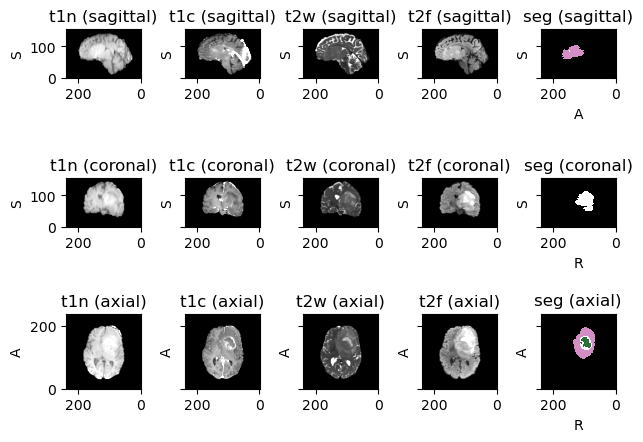

BraTS-SSA-00081-000


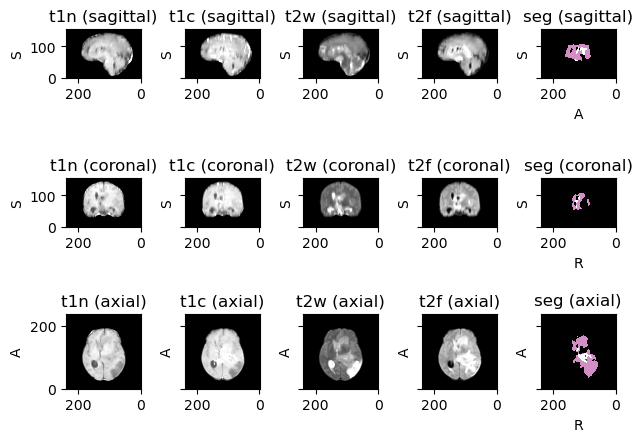

In [15]:
for s in subjs_trans_dataset:
    print(s.name)
    ras = to_ras(s)
    ras.plot()

BraTS-GLI-00002-000
cropping subject using CropOrPad()


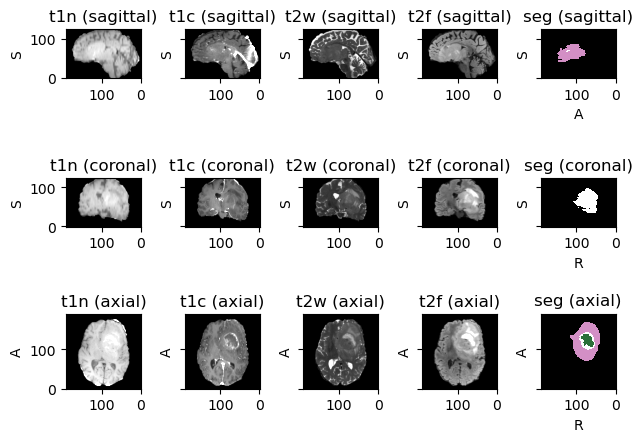

BraTS-SSA-00081-000
cropping subject using CropOrPad()


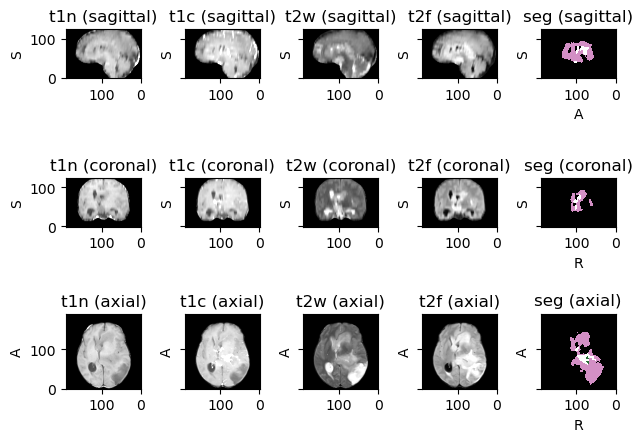

BraTS-GLI-00002-000
cropping subject using CropOrPad()


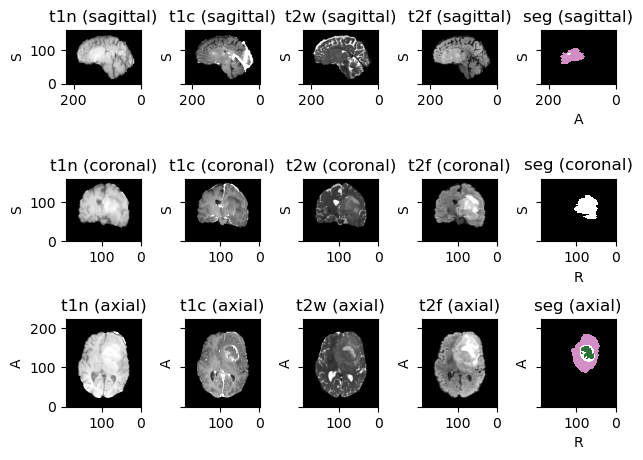

BraTS-SSA-00081-000
cropping subject using CropOrPad()


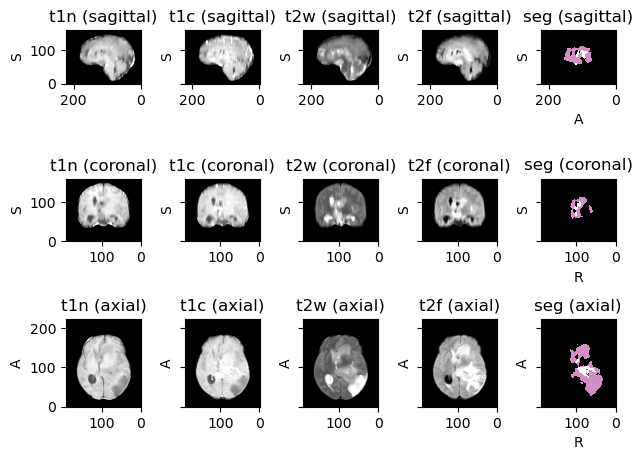

BraTS-GLI-00002-000
cropping subject using CropOrPad()


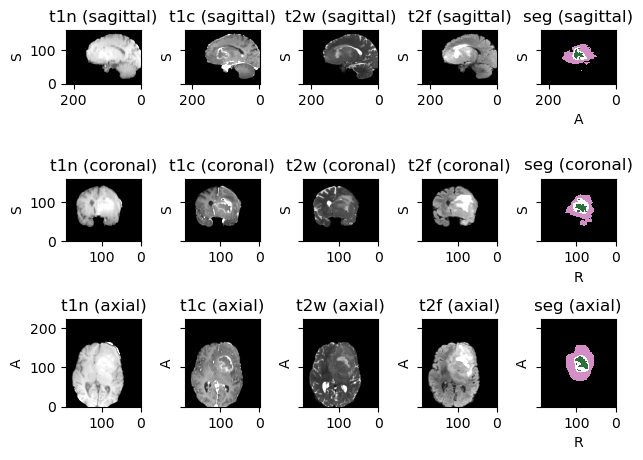

BraTS-SSA-00081-000
cropping subject using CropOrPad()


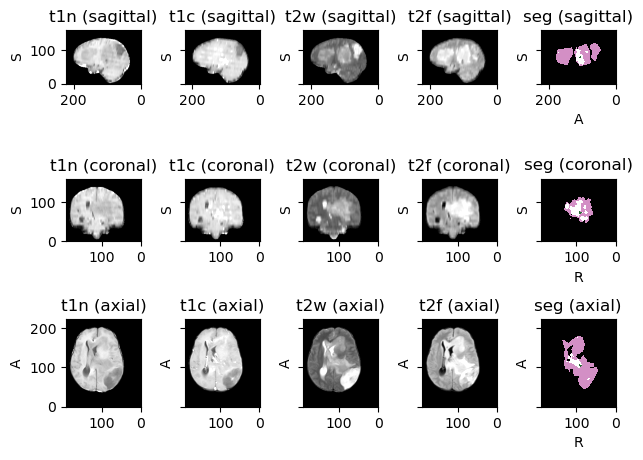

BraTS-GLI-00002-000
cropping subject using CropOrPad()


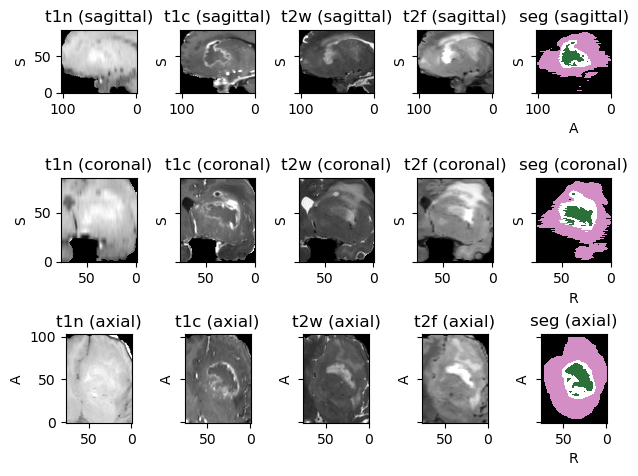

BraTS-SSA-00081-000
cropping subject using CropOrPad()


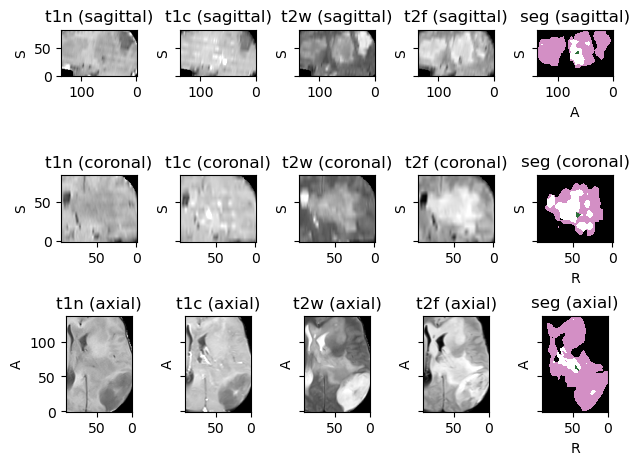

In [17]:
crops = [crop_padSc, crop_padZ, crop_pad_Zlbl, crop_pad_lbl]
for crop in crops:
    for s in subjs_trans_dataset:
        print(s.name)
        print(f"cropping subject using {crop}")
        cropped = crop(s)
        cropped.plot()


Applying RandomFlip() to subject BraTS-GLI-00002-000


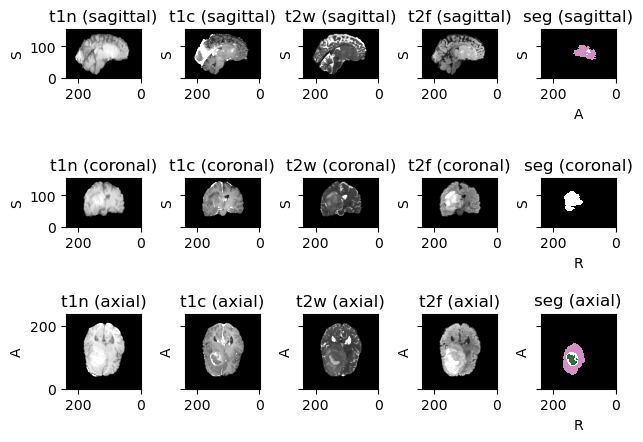

Applying RandomFlip() to subject BraTS-SSA-00081-000


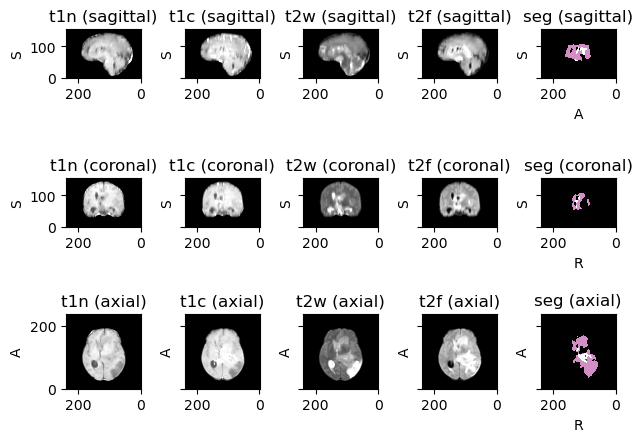

Applying RandomBlur() to subject BraTS-GLI-00002-000


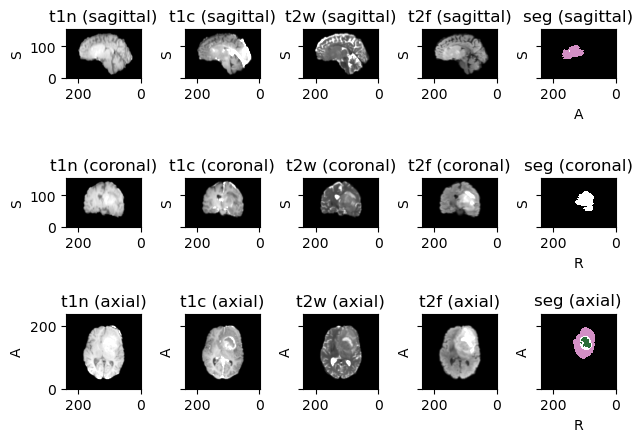

Applying RandomBlur() to subject BraTS-SSA-00081-000


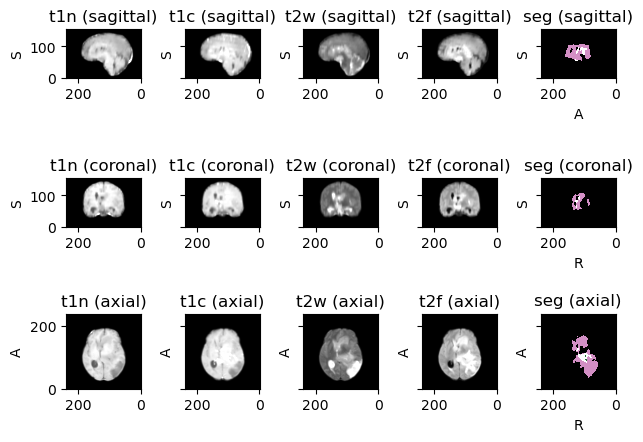

Applying RandomNoise() to subject BraTS-GLI-00002-000


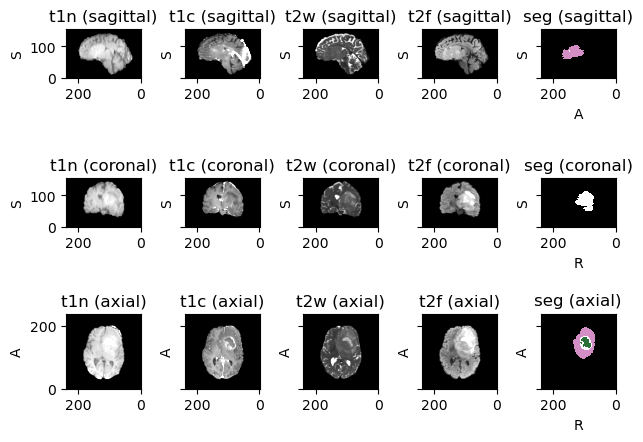

Applying RandomNoise() to subject BraTS-SSA-00081-000


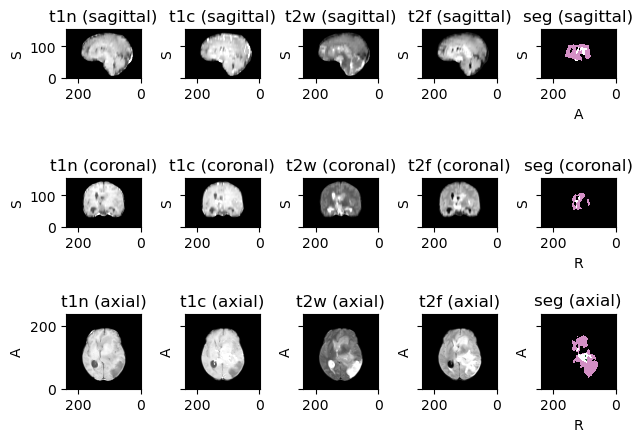

Applying RandomMotion() to subject BraTS-GLI-00002-000


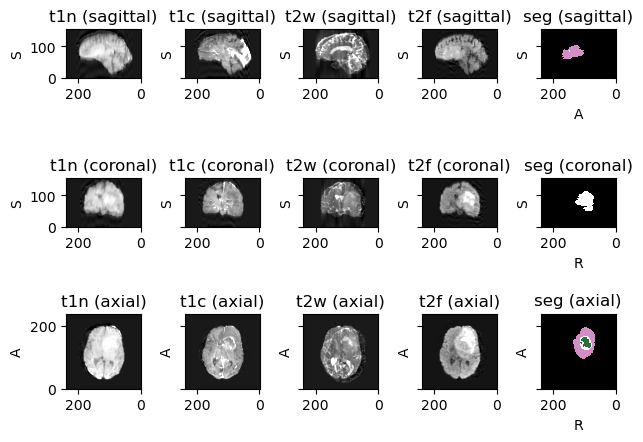

Applying RandomMotion() to subject BraTS-SSA-00081-000


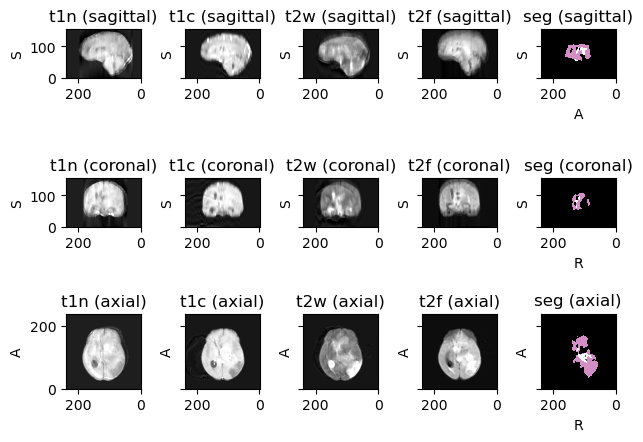

Applying RandomBiasField() to subject BraTS-GLI-00002-000


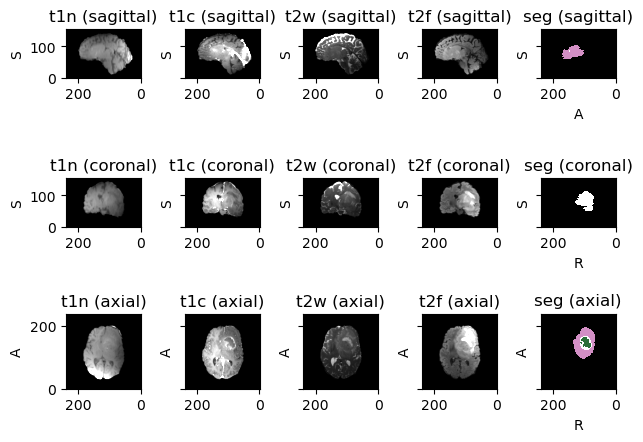

Applying RandomBiasField() to subject BraTS-SSA-00081-000


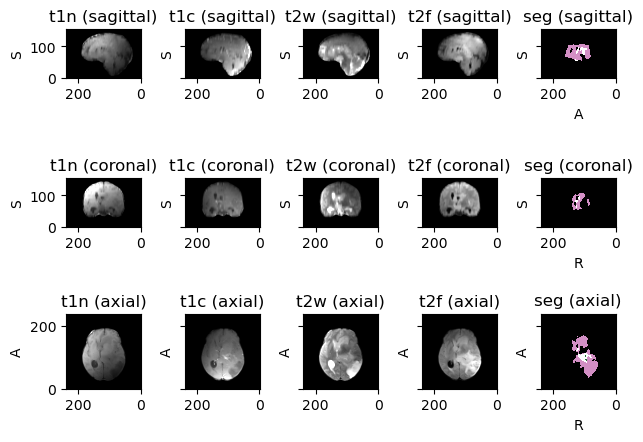

Applying RandomGhosting() to subject BraTS-GLI-00002-000


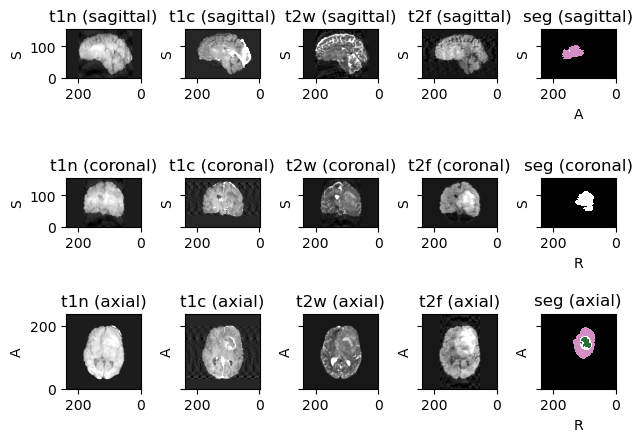

Applying RandomGhosting() to subject BraTS-SSA-00081-000


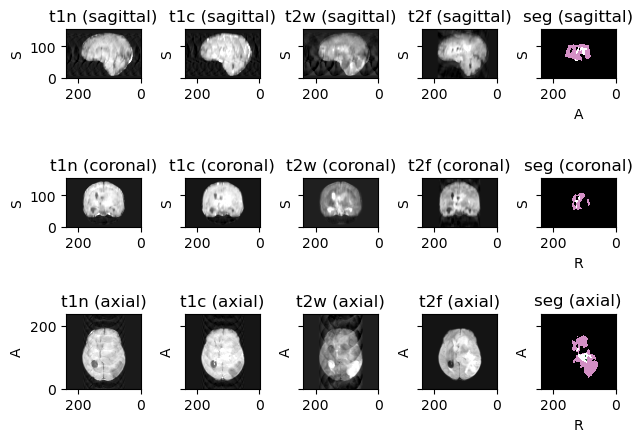

Applying Resample(target=(1.2, 1.2, 6), image_interpolation=linear, label_interpolation=nearest, pre_affine_name=None, scalars_only=False) to subject BraTS-GLI-00002-000


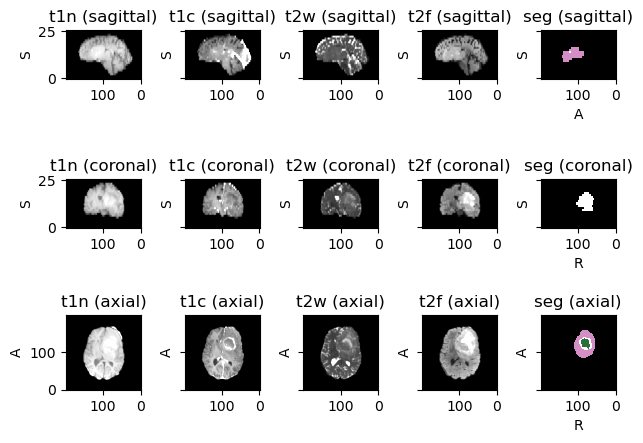

Applying Resample(target=(1.2, 1.2, 6), image_interpolation=linear, label_interpolation=nearest, pre_affine_name=None, scalars_only=False) to subject BraTS-SSA-00081-000


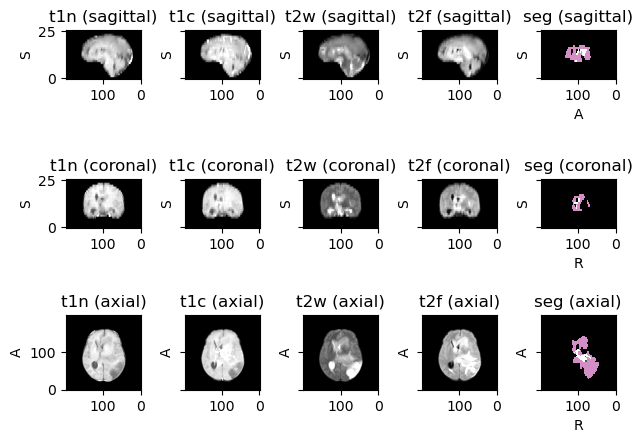

Applying RandomAnisotropy() to subject BraTS-GLI-00002-000


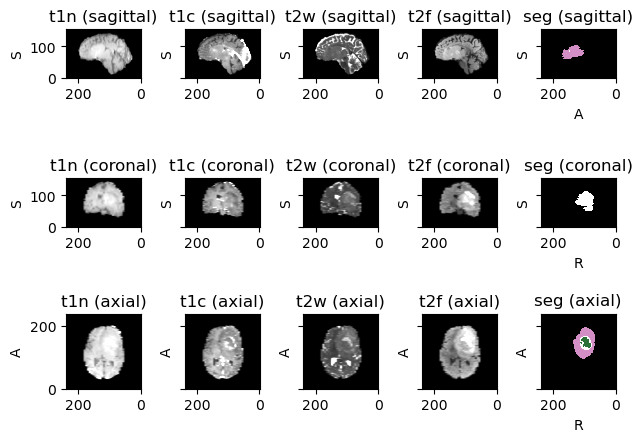

Applying RandomAnisotropy() to subject BraTS-SSA-00081-000


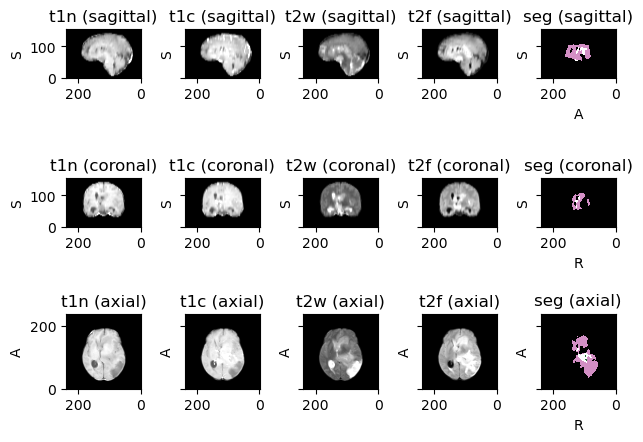

In [20]:
augs = [flipR, blurR, noiseR, motionR, biasfR, ghostR, resampleR, anisoR]
for aug in augs:
    for s in subjs_trans_dataset:
        print(f"Applying {aug} to subject {s.name}")
        ras = to_ras(s)
        augment = aug(ras)
        augment.plot()

In [23]:
import os
import torch
import torchio as tio

data_path = 'C:\\Users\\amoda\\Documents\\SPARK\\BraTS2023\\Data\\Samples\\BraTS-GLI-00002-000\\'
image_path = 'C:\\Users\\amoda\\Documents\\SPARK\\BraTS2023\\Data\\Samples\\BraTS-GLI-00002-000\\BraTS-GLI-00002-000-stk.nii.gz'
label_path = 'C:\\Users\\amoda\\Documents\\SPARK\\BraTS2023\\Data\\Samples\\BraTS-GLI-00002-000\\BraTS-GLI-00002-000-lbl.nii.gz'

# Define the number of classes (including background)
num_classes = 4

# Create the TorchIO subject
subject = tio.Subject(
    image=tio.ScalarImage(os.path.join(data_path, image_path)),
    label=tio.LabelMap(os.path.join(data_path, label_path))
)

ohe = tio.OneHot(num_classes)
ohe_sub = ohe(subject)
transformed_image = ohe_sub["image"].data
transformed_label = ohe_sub["label"].data
# Apply one-hot encoding to the image
one_hot_image = tio.OneHot(num_classes)(subject.image)

# Apply one-hot encoding to the label
one_hot_label = tio.OneHot(num_classes)(subject.label)

# Access the one-hot encoded tensors
one_hot_image_tensor = one_hot_image.data
one_hot_label_tensor = one_hot_label.data


print(transformed_image.shape==one_hot_image_tensor.shape)
print(transformed_label.shape==one_hot_label_tensor.shape)
# # Print the shape of the one-hot encoded tensors
# print(one_hot_image_tensor.shape)
# print(one_hot_label_tensor.shape)
# # Find the minimum and maximum values
# min_value = torch.min(one_hot_label_tensor)
# max_value = torch.max(one_hot_label_tensor)

# # Print the minimum and maximum values
# print("Minimum value:", min_value.item())
# print("Maximum value:", max_value.item())

# print(one_hot_label_tensor[3])

True
True


# FULL VISUALISATION -- NOT WORKING PROPERLY YET

In [ ]:
import os
import matplotlib.pyplot as plt
import torchio as tio

data_dir = 'C:\\Users\\amoda\\Documents\\SPARK\\BraTS2023\\Data\\BraTS2023-SSA-TrainingData\\'
output_dir = 'C:\\Users\\amoda\\Documents\\SPARK\\BraTS2023\\Data\\BraTS2023-SSA-TrainingData\\output'

modalities = ['t1n', 't2w', 't1c', 't2f', 'seg']
views = ['axial', 'sagittal', 'coronal']

transformations = [
    tio.ToCanonical(),
    tio.CropOrPad((192, 224, 160), mask_name="label"),
    tio.CropOrPad((192, 224, 160)),
    tio.CropOrPad((192, 192, 124)),
    tio.CropOrPad(mask_name="label"),
    tio.RandomFlip(axes=(0, 1, 2), p=0.3),
    tio.Resample((1.2, 1.2, 6)),
    tio.RandomAnisotropy(axes=(0, 1, 2), downsampling=(1, 6)),
    tio.RandomBlur(std=(0.5, 1.5)),
    tio.RandomNoise(mean=0, std=(0, 0.33)),
    tio.RandomMotion(num_transforms=3, image_interpolation='nearest'),
    tio.RandomBiasField(coefficients=1),
    tio.RandomGhosting(intensity=1.5)
]

specific_string = 'BraTS-'
folders = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder)) and folder.startswith(specific_string)]
subjects = [subj for subj in folders]

subjects_tio = []
for subject in subjects:
    subject_dir = os.path.join(data_dir, subject)
    subject_images = {}
    
    for modality in modalities:
        file_pth = os.path.join(subject_dir, f'{subject}-{modality}.nii.gz')
        
        if modality == 'seg' and file_pth in seg_p:
            subject_images["label"] = tio.LabelMap(file_pth)
        else:
            subject_images[modality] = tio.ScalarImage(file_pth)
    
    subject_tio = tio.Subject(**subject_images)
    subjects_tio.append(subject_tio)

print(subjects_tio)

for modality in modalities:
    for subject in subjects_tio:
        fig, axes = plt.subplots(len(views), len(transformations), figsize=(20, 20))
        fig.suptitle(f'{subject} - {modality.capitalize()} Transforms')

        for i, view in enumerate(views):
            for j, transformation in enumerate(transformations):
                transformed_image = transformation(subject)

                if view == 'axial':
                    img = transformed_image.plot(axial=True)
                elif view == 'sagittal':
                    img = transformed_image.plot(sagittal=True)
                elif view == 'coronal':
                    img = transformed_image.plot(coronal=True)

                axes[i, j].imshow(img, cmap='gray')
                axes[i, j].axis('off')

                # Save figure as .png file
                filename = f'{modality}_{view}_{j+1}.png'
                plt.savefig(os.path.join(output_dir, filename))

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.close()


In [ ]:
import os
import torch
import torchio as tio
import matplotlib.pyplot as plt

# Set the main data directory path
data_dir = '/scratch/guest187/BraTS2023_OriginalData/TrainingData_release/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2'
output_dir = '/home/guest187/GitRepo_Brats23/UNN_BraTS23/reports'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define the list of transformations to apply
transformations = [
    tio.ToCanonical(),
    tio.CropOrPad((192, 224, 160), mask_name="seg"),
    tio.CropOrPad((192, 224, 160)),
    tio.CropOrPad((192, 192, 124)),
    tio.CropOrPad(mask_name="seg"),
    tio.RandomFlip(axes=(0, 1, 2), p=0.3),
    tio.Resample((1.2, 1.2, 6)),
    tio.RandomAnisotropy(axes=(0, 1, 2), downsampling=(1, 6)),
    tio.RandomBlur(std=(0.5, 1.5)),
    tio.RandomNoise(mean=0, std=(0, 0.33)),
    tio.RandomMotion(num_transforms=3, image_interpolation='nearest'),
    tio.RandomBiasField(coefficients=1),
    tio.RandomGhosting(intensity=1.5)
]

# Iterate through the subject folders
subject_dirs = sorted([os.path.join(data_dir, subject_dir) for subject_dir in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subject_dir))])
for subject_dir in subject_dirs:
    subject_id = os.path.basename(subject_dir)
    print(subject_dir)
    # Create a list to hold the subject's images and labels
    images = []
    labels = []

    # Load each scan modality and segmentation
    for modality in ['t1n', 't1c', 't2w', 't2f']:
        image_path = os.path.join(subject_dir, f'{subject_id}-{modality}.nii.gz')
        image = tio.ScalarImage(image_path)
        images.append(image)

    label_path = os.path.join(subject_dir, f'{subject_id}-seg.nii.gz')
    label = tio.LabelMap(label_path)
    labels.append(label)

    # Create the subject using the images and labels
    subject = tio.Subject(
        t1n=images[0],
        t1c=images[1],
        t2w=images[2],
        t2f=images[3],
        seg=labels[0]
    )

    # Create the dataset with the subject
    dataset = tio.SubjectsDataset([subject])

    # Apply transformations and save the resulting figures
    transformed_subjects = []
    for current_transformation in transformations:
        for current_subject in dataset:
            transformed_subject = current_transformation(current_subject)
            transformed_subjects.append(transformed_subject)

transformed_dataset = tio.SubjectsDataset(transformed_subjects)

In [ ]:
# Create a figure for all views
fig, axes = plt.subplots(len(subject_dirs), 4, figsize=(12, 3 * len(subject_dirs)))

# Iterate through the transformed subjects and plot the images
for subject_index, transformed_subject in enumerate(transformed_dataset):
    # Get the transformed images and labels
    transformed_images = [transformed_subject['t1n'], transformed_subject['t1c'], transformed_subject['t2w'], transformed_subject['t2f']]
    transformed_label = transformed_subject['seg']

    # Iterate through the views and plot the images
    for j, view in enumerate(['axial', 'coronal', 'sagittal']):
        ax = axes[subject_index, j]
        ax.imshow(transformed_images[j].data.squeeze().numpy()[:,:,view])
        ax.axis('off')
        ax.set_title(f'{modality.upper()} {view}')

    # Plot the segmentation label for the current subject
    ax = axes[subject_index, 3]
    ax.imshow(transformed_label.data.squeeze().numpy()[:,:,view])
    ax.axis('off')
    ax.set_title('Segmentation')

# Save the figure as an EPS file
output_filename = f'all_subjects_{view}_{transformation.name}.eps'
output_path = os.path.join(output_dir, output_filename)
plt.savefig(output_path, format='eps')

plt.close(fig)

In [ ]:
# Create a figure for all views
fig, axes = plt.subplots(len(subject_dirs), 4, figsize=(12, 3 * len(subject_dirs)))

# Iterate through the transformed subjects and plot the images
for subject_index, transformed_subject in enumerate(transformed_dataset):
    # Get the transformed images and labels
    transformed_images = [transformed_subject['t1n'], transformed_subject['t1c'], transformed_subject['t2w'], transformed_subject['t2f']]
    transformed_label = transformed_subject['seg']

# Iterate through the views and plot the images
    for j, view in enumerate(['axial', 'coronal', 'sagittal']):
        ax = axes[subject_index, j]
        # Convert view to an integer if necessary
        if isinstance(view, str):
            view = {'axial': 0, 'coronal': 1, 'sagittal': 2}[view]
        ax.imshow(transformed_images[j].data.squeeze().numpy()[:,:,view])
        ax.axis('off')
        ax.set_title(f'{modality.upper()} {view}')

        # Plot the segmentation label for the current subject
        ax = axes[subject_index, 3]
        ax.imshow(transformed_label.data.squeeze().numpy()[:,:,view])
        ax.axis('off')
        ax.set_title('Segmentation')

# Save the figure as an EPS file
output_filename = f'all_subjects_{view}_{transformation.name}.eps'
output_path = os.path.join(output_dir, output_filename)
plt.savefig(output_path, format='eps')

plt.close(fig)